# Train the chatbot

This is remotely based on the amalgamation of [this](https://github.com/saltypaul/Seq2Seq-Chatbot)
and [that](https://github.com/marekrei/sequence-labeler) repositories. The images are taken from
the first one.

In [1]:
import os
import time
import json
import pickle

import numpy as np

import pandas as pd
import tqdm

We'll definitely need to plot something

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

Uninterruptible section

In [3]:
import signal

class DelayedKeyboardInterrupt(object):
    def __enter__(self):
        self.signal_received = False
        self.old_handler = signal.getsignal(signal.SIGINT)
        signal.signal(signal.SIGINT, self.handler)

    def handler(self, sig, frame):
        self.signal_received = (sig, frame)

    def __exit__(self, type, value, traceback):
        signal.signal(signal.SIGINT, self.old_handler)
        if self.signal_received:
            self.old_handler(*self.signal_received)

Fix the random seed

In [4]:
random_state = np.random.RandomState(0x0BADC0DE)

Import Theano and Lasagne

In [5]:
# %env THEANO_FLAGS='device=cuda0,force_device=True,mode=FAST_RUN,floatX=float32'

import theano
theano.config.exception_verbosity = 'high'

import theano.tensor as tt

import lasagne
from lasagne.utils import floatX

Using cuDNN version 5103 on context None
Mapped name None to device cuda: GeForce GTX 980 Ti (0000:06:00.0)


Fix Lasagne's random seed.

In [6]:
lasagne.random.set_rng(np.random.RandomState(0xDEADC0DE))

Load the line lookup table. It was generated from the [Cornell Movie--Dialogs Corpus](https://people.mpi-sws.org/~cristian/Cornell_Movie-Dialogs_Corpus.html)

In [7]:
with open("../processed_lines.json", "r", encoding="utf-8") as fin:
    db_lines = {k: "\x02" + v + "\x03" for k, v in json.load(fin).items()}

Load the diaogues into Q&A pairs

In [8]:
with open("../processed_dialogues.json", "r", encoding="utf-8") as fin:
    db_dialogues = json.load(fin)

qa_pairs = []
for lines in db_dialogues:
    qa_pairs.extend(zip(lines[:-1], lines[1:]))
del db_dialogues

# for easier indexing
qa_pairs = np.array(qa_pairs)

Build the vocabulary

In [9]:
from collections import Counter
token_counts = Counter(c for l in db_lines.values() for c in l[1:-1])

## It is very important that these service characters be added first
vocab = ["\x02", "\x03"]
vocab += [c for c, f in token_counts.items()]

token_to_index = {w: i for i, w in enumerate(vocab)}

A function to lines into character id vectors.

In [10]:
def as_matrix(lines, max_len=None):
    if isinstance(lines, str):
        lines = [lines]

    length = max(map(len, lines))
    length = min(length, max_len or length)

    matrix = np.full((len(lines), length), -1, dtype='int32')
    for i, line in enumerate(lines):
        row_ix = [token_to_index.get(c, -1)
                  for c in line[:length]]

        matrix[i, :len(row_ix)] = row_ix

    return matrix

A function to convert History-Reply pairs into character id matrices

In [11]:
def retrieve_sentences(pairs):
    enc, dec = [], []
    for q, a in pairs:
        enc.append(db_lines[q])
        dec.append(db_lines[a])
    return enc, dec

def get_matrices(pairs, max_len=None):
    enc, dec = retrieve_sentences(pairs)
    return as_matrix(enc, max_len), as_matrix(dec, max_len)

A function to sample a batch from History-Reply pairs

In [12]:
def generate_batch(batch_size=32, max_len=None):
    n_batches = (len(qa_pairs) + batch_size - 1) // batch_size
    indices_ = random_state.permutation(len(qa_pairs))
    
    for i in range(n_batches):
        yield get_matrices(qa_pairs[indices_[i::n_batches]], max_len)

Define a simple seq2seq network (preferably in Lasagne)

In [13]:
from lasagne.layers import InputLayer, EmbeddingLayer
from lasagne.layers import GRULayer, DenseLayer
from lasagne.layers import NonlinearityLayer

from broadcast import BroadcastLayer, UnbroadcastLayer
from lasagne.layers import SliceLayer

from lasagne.layers.base import Layer

from GRUwithAttention import GRUAttentionLayer

The architecture hyper parameters

In [14]:
model_file = "pickles/attention_mdl_epoch-20.pkl"
if os.path.exists(model_file):
    with open(model_file, "rb") as fin:
        ver, *rest = pickle.load(fin)
        assert ver == "GRUAttentionLayer"

    hyper, vocab, weights = rest

else:
    hyper = {
        "n_embed_char": 32,
        "n_hidden_decoder": 256,
        "n_hidden_encoder": 256,
        "n_layers_decoder": 2,
        "n_attention_decoder": 256,
    }

Set shortcuts

In [15]:
n_embed_char = hyper["n_embed_char"]          # 32
n_hidden_encoder = hyper["n_hidden_encoder"]  # 256
n_hidden_decoder = hyper["n_hidden_decoder"]  # 256
n_layers_decoder = hyper["n_layers_decoder"]  # 4
n_attention_decoder = hyper["n_attention_decoder"]  # 256

<img src="https://raw.githubusercontent.com/saltypaul/Seq2Seq-Chatbot/master/pics/Training%20Phase.jpg" />

### Embedding subgraph (pinkish)

A helper function to initialize GRU layer with attention

In [16]:
def gruattn_column(input, context, num_units, num_attn_units, **kwargs):
    kwargs.pop("only_return_final", None)
    name = kwargs.pop("name", "default")
    column = [input]
    for i, n_units in enumerate(num_units):
        layer = GRUAttentionLayer(column[-1], context, n_units, num_attn_units,
                                  name=os.path.join(name, "gruattn_%02d" % i),
                                  **kwargs)
        column.append(layer)
    return column[1:]

Create readouts of the last hidden state

In [17]:
def gru_hidden_readout(column, indices):
    hidden = []
    for layer in column:
        name = os.path.join(layer.name, "slice")
        slice_ = SliceLayer(layer, indices, axis=1, name=name)
        hidden.append(slice_)
    return hidden

### Encoder

Tap into the common embedding layer

In [18]:
l_encoder_mask = InputLayer((None, None), name="encoder/mask")
l_encoder_embed = InputLayer((None, None, n_embed_char), name="encoder/input")

### Sentence representation

Construct layered GRU columns atop the embedding (we can also make parallel fwd / rev layers)

In [19]:
from lasagne.layers import ConcatLayer

bidi_gru = []
bidi_gru.append(GRULayer(l_encoder_embed, n_hidden_encoder, learn_init=True,
                         name="encoder/gru_f", backwards=False))
bidi_gru.append(GRULayer(l_encoder_embed, n_hidden_encoder, learn_init=True,
                         name="encoder/gru_b", backwards=True))

l_encoder_context = ConcatLayer(bidi_gru, axis=-1, name="encoder/cat")

### Decoder

Tap into the common embedding layer but with decoder's own input.

In [20]:
l_decoder_mask = InputLayer((None, None), name="decoder/mask")
l_decoder_embed = InputLayer((None, None, n_embed_char), name="decoder/input")

Construct layers of GRU-s which recieve the final state of the encoder's network.

In [21]:
n_units = n_layers_decoder * [n_hidden_decoder]
dec_rnn_layers = gruattn_column(l_decoder_embed, l_encoder_context, n_units,
                                n_attention_decoder, mask_input=l_decoder_mask,
                                learn_init=True, backwards=False,
                                context_mask_input=l_encoder_mask, name="decoder")

dec_rnn_layers_sliced = gru_hidden_readout(dec_rnn_layers, -1)

Read the output of the top layer of the RNN and re-embed into the character space

In [22]:
l_decoder_reembedder = DenseLayer(dec_rnn_layers[-1], num_units=len(vocab),
                                  nonlinearity=None, num_leading_axes=2,
                                  name="decoder/project")

Construct the softmax layer

In [23]:
l_bc = BroadcastLayer(l_decoder_reembedder, broadcasted_axes=(0, 1), name="decoder/bc")
l_softmax = NonlinearityLayer(l_bc, nonlinearity=lasagne.nonlinearities.softmax, name="decoder/softmax")
l_decoder_output = UnbroadcastLayer(l_softmax, l_bc, name="decoder/ub")

### Embedding layer 

The common embedding layer

In [24]:
l_input_char = InputLayer((None, None), name="char/input")
l_embed_char = EmbeddingLayer(l_input_char, len(vocab), n_embed_char, name="char/embed")

### Resume training

In [25]:
if "weights" in locals():
    lasagne.layers.set_all_param_values(l_embed_char,
                                        weights["l_embed_char"])
    lasagne.layers.set_all_param_values(l_decoder_reembedder,
                                        weights["l_decoder_reembedder"])

### Loss

Collect the encoder input

In [26]:
v_encoder_input = tt.imatrix(name="encoder/input")
v_encoder_embed = l_embed_char.get_output_for(v_encoder_input)

inputs = {l_encoder_embed: v_encoder_embed,
          l_encoder_mask: tt.ge(v_encoder_input, 0)}

And the decoder's inputs

In [27]:
v_decoder_input = tt.imatrix(name="decoder/input")
v_decoder_embed = lasagne.layers.get_output(l_embed_char, v_decoder_input)

inputs.update({l_decoder_embed: v_decoder_embed,
               l_decoder_mask: tt.ge(v_decoder_input, 0)})

Get the output of the decoder

In [28]:
v_decoder_output, v_decoder_mask = lasagne.layers.get_output(
    [l_decoder_output, l_decoder_mask], inputs, deterministic=False)

Slice the output to match the forward character-level language model

In [29]:
v_predicted = v_decoder_output[:, :-1].reshape(
    (-1, v_decoder_output.shape[-1]))

v_targets = v_decoder_input[:, 1:].reshape((-1,))

v_mask = v_decoder_mask[:, 1:].reshape((-1,))

Construct the cross-entropy loss

In [30]:
loss_ij = lasagne.objectives.categorical_crossentropy(v_predicted, v_targets)
loss = (loss_ij * v_mask).sum()
loss /= v_mask.sum()

It can be benefitial to project the character embeddings onto the unit sphere.
However we are going to project the embeddings into the unit $l^2$ ball instead.

In [31]:
W_emb = l_embed_char.get_params()[0]

op_project_embedding = theano.function([], updates={
    W_emb: W_emb / tt.maximum(W_emb.norm(2, axis=-1, keepdims=True), 1.0)
})

On the other hand we can always add $l^2$ regularization term.

In [32]:
if False:
    C_embed = 1e-1
    loss += C_embed * W_emb.norm(2, axis=-1).mean()

Collect all trainable parameters 

In [33]:
trainable = []
trainable.extend(lasagne.layers.get_all_params(l_embed_char, trainable=True))
trainable.extend(lasagne.layers.get_all_params(l_decoder_output, trainable=True))

Get the updates

In [34]:
learning_rate = theano.shared(floatX(1e-3), name="eta")

# updates = lasagne.updates.sgd(loss, trainable, learning_rate)
updates = lasagne.updates.adam(loss, trainable, learning_rate)

Create the ops

In [35]:
op_train = theano.function([v_decoder_input, v_encoder_input], loss,
                           updates=updates, givens={},
                           mode=theano.Mode(optimizer="fast_run"))

In [36]:
v_decoder_logits = lasagne.layers.get_output(l_decoder_reembedder, inputs, deterministic=True)

op_predict_logits = theano.function([v_decoder_input, v_encoder_input],
                                     v_decoder_logits, mode=theano.Mode(optimizer="fast_run"))

In [37]:
trainable

[char/embed.W,
 encoder/gru_f.W_in_to_updategate,
 encoder/gru_f.W_hid_to_updategate,
 encoder/gru_f.b_updategate,
 encoder/gru_f.W_in_to_resetgate,
 encoder/gru_f.W_hid_to_resetgate,
 encoder/gru_f.b_resetgate,
 encoder/gru_f.W_in_to_hidden_update,
 encoder/gru_f.W_hid_to_hidden_update,
 encoder/gru_f.b_hidden_update,
 encoder/gru_f.hid_init,
 encoder/gru_b.W_in_to_updategate,
 encoder/gru_b.W_hid_to_updategate,
 encoder/gru_b.b_updategate,
 encoder/gru_b.W_in_to_resetgate,
 encoder/gru_b.W_hid_to_resetgate,
 encoder/gru_b.b_resetgate,
 encoder/gru_b.W_in_to_hidden_update,
 encoder/gru_b.W_hid_to_hidden_update,
 encoder/gru_b.b_hidden_update,
 encoder/gru_b.hid_init,
 decoder/gruattn_00.W_in,
 decoder/gruattn_00.W_ctx,
 decoder/gruattn_00.W_hid,
 decoder/gruattn_00.b,
 decoder/gruattn_00.v_attn,
 decoder/gruattn_00.b_attn,
 decoder/gruattn_00.hid_init,
 decoder/gruattn_01.W_in,
 decoder/gruattn_01.W_ctx,
 decoder/gruattn_01.W_hid,
 decoder/gruattn_01.b,
 decoder/gruattn_01.v_attn,
 de

### The generator

<img src="https://raw.githubusercontent.com/saltypaul/Seq2Seq-Chatbot/master/pics/Eval.jpg" />

A handy slicer (copied and modified)

In [38]:
def slice_(x, i, n):
    s = x[..., slice(i, i + n)]
    return s if n > 1 else tt.addbroadcast(s, -1)

Define one step of the scan function

In [39]:
# Generator's one step update function
def generator_step_sm(x_tm1, h_tm1, m_tm1, ctx, ctx_mask, tau, eps):
    """One step of the generative decoder version."""
    # x_tm1 is `BxT` one-hot, h_tm1 is `batch x ...`
    # m_tm1 is `batch`, tau, eps are scalars

    # collect the inputs
    inputs = {l_decoder_embed: x_tm1.dimshuffle(0, "x", 1),
              l_decoder_mask: m_tm1.dimshuffle(0, "x"),
              l_encoder_mask: ctx_mask,
              l_encoder_context: ctx}

    # Connect the prev variables to the the hidden and stack state feeds
    j = 0
    for layer in dec_rnn_layers:
        inputs[layer.hid_init] = slice_(h_tm1, j, layer.num_units)
        j += layer.num_units

    # Get the outputs
    outputs = [l_decoder_reembedder] + dec_rnn_layers_sliced

    # propagate through the decoder column
    logit_t, *h_t_list = lasagne.layers.get_output(outputs, inputs,
                                                   deterministic=True)

    # Pack the hidden states
    h_t = tt.concatenate(h_t_list, axis=-1)
    
    # Generate the next symbol: logit_t is `Bx1xV`
    logit_t = logit_t[:, 0]
    prob_t = tt.nnet.softmax(logit_t)

    # Gumbel-softmax sampling: Gumbel (e^{-e^{-x}}) distributed random noise
    gumbel = -tt.log(-tt.log(theano_random_state.uniform(size=logit_t.shape) + eps) + eps)
#     logit_t = theano.ifelse.ifelse(tt.gt(tau, 0), gumbel + logit_t, logit_t)
#     inv_temp = theano.ifelse.ifelse(tt.gt(tau, 0), 1.0 / tau, tt.constant(1.0))
    logit_t = tt.switch(tt.gt(tau, 0), gumbel + logit_t, logit_t)
    inv_temp = tt.switch(tt.gt(tau, 0), 1.0 / tau, tt.constant(1.0))

    # Get the softmax: x_t is `BxV`
    x_t = tt.nnet.softmax(logit_t * inv_temp)

    # Get the best symbol
    c_t = tt.cast(tt.argmax(x_t, axis=-1), "int8")

    # Get the estimated probability of the picked symbol.
    p_t = prob_t[tt.arange(c_t.shape[0]), c_t]

    # Compute the mask and inhibit the propagation on a stop symbol.
    # Recurrent layers return the previous state if m_tm1 is Fasle
    m_t = m_tm1 & tt.gt(c_t, vocab.index("\x03"))
    c_t = tt.switch(m_t, c_t, vocab.index("\x03"))

    # There is no need to freeze the states as they will be frozen by
    # the RNN passthrough according to the mask `m_t`.

    # Embed the current character.
    x_t = tt.dot(x_t, l_embed_char.W)

    return x_t, h_t, m_t, p_t, c_t

Create scalar inputs to the scan loop. Also initialize the random stream.

In [40]:
theano_random_state = tt.shared_randomstreams.RandomStreams(seed=42)

eps = tt.fscalar("generator/epsilon")
n_steps = tt.iscalar("generator/n_steps")
tau = tt.fscalar("generator/gumbel/tau")

Let's compile an autofeeding generator with softmax.

In [41]:
v_gen_input = tt.imatrix(name="generator/Q_input")

v_gen_embed = lasagne.layers.get_output(l_embed_char, v_gen_input)

Helper functions to freeze the GRULayer's hidden input's initialization,
if one is a parameter.

In [42]:
def GRULayer_freeze(layer, input):
    assert isinstance(layer, (GRULayer, GRUAttentionLayer))
    if isinstance(layer.hid_init, Layer):
        return layer

    assert not (layer.hid_init_incoming_index > 0)
    assert isinstance(layer.hid_init, theano.compile.SharedVariable)

    # Broadcast the fixed /learnt hidden init over the batch dimension
    hid_init = tt.dot(tt.ones((input.shape[0], 1)), layer.hid_init)

    # Create a fake Input Layer, which receives it as input
    layer._old_hid_init = layer.hid_init
    layer.hid_init = InputLayer((None, None), input_var=hid_init,
                                name=os.path.join(layer.name,
                                                  "hid_init_fix"))
    
    # Cache former values
    layer._old_input_layers = layer.input_layers
    layer._old_input_shapes = layer.input_shapes
    layer._old_hid_init_incoming_index = layer.hid_init_incoming_index
    
    # Emulate hidden layer input (is in GRULayer/MergeLayer.__init__())
    layer.input_layers.append(layer.hid_init)
    layer.input_shapes.append(layer.hid_init.output_shape)
    layer.hid_init_incoming_index = len(layer.input_layers) - 1

    layer._layer_frozen = True
    return layer

Freeze the hidden inputs of the decoder layers, which do not tap into the encoder.

In [43]:
for layer in dec_rnn_layers:
    GRULayer_freeze(layer, v_gen_input)

Readout the last state from the encoder.

In [44]:
inputs = {l_encoder_embed: v_gen_embed,
          l_encoder_mask: tt.ge(v_gen_input, 0)}
outputs = [l_encoder_context] + [l.hid_init for l in dec_rnn_layers]

context, *dec_hid_inits = lasagne.layers.get_output(outputs, inputs,
                                                    deterministic=True)
context_mask = inputs[l_encoder_mask]

Prepare the initial values.

In [45]:
h_0 = tt.concatenate(dec_hid_inits, axis=-1)

x_0 = tt.fill(tt.zeros((v_gen_input.shape[0],), dtype="int32"),
              vocab.index("\x02"))
x_0 = lasagne.layers.get_output(l_embed_char, x_0)

m_0 = tt.ones((v_gen_input.shape[0],), 'bool')

Add a scan op and compile

In [46]:
result, updates = theano.scan(generator_step_sm, sequences=None, n_steps=n_steps,
                              outputs_info=[x_0, h_0, m_0, None, None],
                              strict=False, return_list=True,
                              non_sequences=[context, context_mask, tau, eps],
                              go_backwards=False, name="generator/scan")
x_t, h_t, m_t, p_t, c_t = [r.swapaxes(0, 1) for r in result]

compile_mode = theano.Mode(optimizer="fast_run", linker="cvm")
op_generate = theano.function([v_gen_input, n_steps, tau],
                              [c_t, h_t, m_t, p_t],
                              updates=updates, givens={eps: floatX(1e-20)},
                              mode=compile_mode)

This function undoes the frrezing by the previous one

In [47]:
def GRULayer_unfreeze(layer):
    assert isinstance(layer, (GRULayer, GRUAttentionLayer))
    freeze_attr = ["_layer_frozen",
                   "_old_input_layers", "_old_input_shapes",
                   "_old_hid_init_incoming_index", "_old_hid_init"]
    if not all(hasattr(layer, a) for a  in freeze_attr):
        return layer

    assert layer._layer_frozen
    assert isinstance(layer.hid_init, Layer)
    assert layer.hid_init.name.endswith("/hid_init_fix")

    # Thawe the frozen hidden input
    layer.hid_init = layer._old_hid_init
    layer.input_layers = layer._old_input_layers
    layer.input_shapes = layer._old_input_shapes
    layer.hid_init_incoming_index = layer._old_hid_init_incoming_index
    
    for attr in freeze_attr:
        delattr(layer, attr)

    return layer

Unfreeze the decoder's layer, so that those which do not tap in to the encoder,
may continue to use / learn their own `hid_init` state.

In [48]:
for layer in dec_rnn_layers:
    GRULayer_unfreeze(layer)

A generator procedure, which automatically selects the best replies (lowest perplexity).

In [49]:
def generate(questions, n_steps, n_samples=10, tau=0, seed=None):
    results = []
    for question in questions:
        # Replicate the query
        question = np.repeat(question[np.newaxis], n_samples, axis=0)
        if seed is not None:
            theano_random_state.seed(seed)

        x_t, h_t, m_t, p_t = op_generate(question, n_steps, tau)

        # may produce NaN, but they are shifted in the back by arsort
        perplexity, n_chars = (- np.log2(p_t) * m_t).sum(axis=-1), m_t.sum(axis=-1)
        perplexity /= n_chars

        result = []
        for i in perplexity.argsort():
            reply = "".join(map(vocab.__getitem__, x_t[i, :n_chars[i]]))
            result.append((reply, perplexity[i]))
        results.append(result)
    return results

<br/>

### Train the BOT

In [50]:
def sample_qa():
    sample = qa_pairs[random_state.choice(len(qa_pairs), 3)]
    enc, dec = retrieve_sentences(sample)

    replies = generate(as_matrix(enc), 140, tau=2**-10, n_samples=20)
    for e, d, r in zip(enc, dec, replies):
        tqdm.tqdm.write("|%-40.40s | %-30.30s | %-30.30s|" % (e[1:-1], d[1:-1], r[0][0]))

Set the batch size and the number of epochs.

In [56]:
batch_size, n_epochs = 160, 20
epoch, loss_val_hist = 0, []

model_path = os.path.join("pickles", time.strftime("%Y%m%d-%H%M%S"))
if not os.path.exists(model_path):
    os.makedirs(model_path)

filename_fmt_ = os.path.join(model_path, "attention_mdl_epoch-%02d%s.pkl")

Now let's train the shit!

In [85]:
n_epochs = 20

In [86]:
progress_fmt_, interrupted = "%(epoch)02d: %(loss).3f", False
n_batches = (len(qa_pairs) + batch_size - 1) // batch_size
while epoch < n_epochs:
    try:
        with tqdm.tqdm(total=n_batches) as progress_:
            for i, (be, bd) in enumerate(generate_batch(batch_size, max_len=128)):
                if (i % 100) == 0:
                    sample_qa()

                with DelayedKeyboardInterrupt():
                    loss_val_hist.append(op_train(bd, be))
                    # op_project_embedding()

                progress_.postfix = progress_fmt_ % {
                    "loss": np.mean(loss_val_hist[-100:]),
                    "epoch": epoch,
                }
                progress_.update(1)
            # end for

        # end with
        epoch += 1
    except KeyboardInterrupt:
        interrupted = True

    finally:
        # retrieve the parameters
        weights = {
            "l_embed_char": lasagne.layers.get_all_param_values(l_embed_char),
            "l_decoder_reembedder": lasagne.layers.get_all_param_values(l_decoder_reembedder)
        }
        filename = filename_fmt_ % (epoch, "_interrupted" if interrupted else "")
        with open(filename, "wb") as fin:
            pickle.dump(("GRUAttentionLayer", hyper, vocab, weights), fin)

        if interrupted:
            break

  0%|          | 0/1386 [00:01<?, ?it/s]

|I mean, what are the three terrors of th | Westley, what about the R.O.U. | But I don't like that. I think|
|You haven't mentioned dating anyone sinc | No, I'm not a lesbian. Geez mo | I know what I said.           |
|You are bitter, Athos. You are torn by g | He who is not with us is again | Thank you. I love you can't pu|


  7%|▋         | 100/1386 [04:38<59:20,  2.77s/it, 10: 1.184] 

|And I changed the schedule.              | I don't work for you, Captain  | Okay. Let's say you did that! |
|You just called me Ivy. Who's Ivy?       | I wish I knew.                 | I don't know...               |
|Det. Bradford, I'm sorry but we don't al | Sorry, ma'am. We're investigat | You're welcome.               |


 14%|█▍        | 200/1386 [09:15<54:43,  2.77s/it, 10: 1.187]  

|Will you stay here for the night? You ca | Don't worry about it. I'll sta | Or sweetheart.                |
|Okay... dead or undead... what do you wa | A-duh... You're a werewolf. An | Don't listen to me.           |
|It's a regular college. It's just run by | And you spend all your time ju | It's very important.          |


 22%|██▏       | 300/1386 [13:53<50:06,  2.77s/it, 10: 1.188]

|I'm looking for...                       | He said, and these were his wo | What's wrong?                 |
|What is it?                              | The cop who found the knife in | I don't know that.            |
|You're in there. Everybody dies, you go  | - But don't you remember? I'm  | Yeah.                         |


 29%|██▉       | 400/1386 [18:30<45:29,  2.77s/it, 10: 1.193]

|He was my blood - and I demand to know w | Why would you ask now? You nev | It was born. Do you know what |
|Just those two loose-cannon cops running | Yeah. Pretty zany, huh? All th | I can't do somethin'.         |
|Who?                                     | The other agent. He said he wa | The one who thinks I don't kno|


 36%|███▌      | 500/1386 [23:08<40:52,  2.77s/it, 10: 1.195]

|Josh!                                    | Well come on, sit down.        | Please don't do isaul five min|
|I hear you brought a film clip with you. | Well, it pretty much speaks fo | Well, I'm sorry.              |
|Huh. That explains all the tannins. And  | About a year.                  | I don't know. It's all right, |


 43%|████▎     | 600/1386 [27:45<36:16,  2.77s/it, 10: 1.196]

|Sure. Why?                               | It's Saturday morning. Let's g | I wouldn't know what everying |
|Anything else you -                      | Not from you.                  | Yeah. Well, I don't love you a|
|What do you want to carry that gun aroun | You want to talk about regrets | I don't know what I imagincs b|


 51%|█████     | 700/1386 [32:23<31:39,  2.77s/it, 10: 1.194]

|Yeah, watch the road!                    | You'll total the whole car.    | What are you going to disapure|
|So, what good is it to us if it's been e | It's very good - because when  | It was a man who has no one to|
|Why; naturally, I                        | Naturally. You're going to bec | Shall I have your refrensauris|


 58%|█████▊    | 800/1386 [37:00<27:02,  2.77s/it, 10: 1.193]

|Why wait?                                | I'm not going to wait. I'm goi | It's not better.              |
|My gentle Captain... I'm staying.        | I - I don't understand...      | How do you know about this?   |
|When does it break?                      | Couple of days. Anyhow, look a | It means you do something.    |


 65%|██████▍   | 900/1386 [41:37<22:25,  2.77s/it, 10: 1.195]

|Hey. Where's Monkeybone?                 | Back in your head, where he be | I told me that.               |
|I'd rather you didn't.                   | Do you have a girlfriend?      | I'd like to do that.          |
|How can you tell?                        | R.E.M.'s. Rapid eye movements. | I don't know.                 |


 72%|███████▏  | 1000/1386 [46:15<17:48,  2.77s/it, 10: 1.196]

|I have... eight-fifteen. That's not righ | It's three-thirty, Grady.      | I don't know, please. I'm inte|
|He's a nigger.                           | Yeah. And uh, he's pissed off. | You're a lawyer.              |
|...along.                                | Oh, no - please. I have to res | I wasn't there.               |


 79%|███████▉  | 1100/1386 [50:52<13:11,  2.77s/it, 10: 1.195]

|You'd want to make that go away. You'd w | And what if I couldn't do that | Would you read me?            |
|Thank you, John.                         | You're welcome, Grace.         | Uh-huh. You've got to walk.   |
|What?                                    | The doctor said you were havin | What do you know that?        |


 87%|████████▋ | 1200/1386 [55:30<08:34,  2.77s/it, 10: 1.197]

|What the hell happened?                  | Engine room, what happened?    | Nothing.                      |
|...Not enough food?                      | Negatory. uToo many antsu. And | I don't like it. I'll figure t|
|Zira doesn't want your female.           | I want her.                    | Max, I don't think he's bukiev|


 94%|█████████▍| 1300/1386 [1:00:06<03:56,  2.76s/it, 10: 1.193]

|Coffey, we're a little pressed for time. | Monk, Schoenick... secure the  | You won't believe that?       |
|Where can we talk?                       | Right here.                    | Where is that?                |
|The pepper, too?                         | No, thank you.                 | Yes.                          |


  0%|          | 0/1386 [00:00<?, ?it/s]

|Are uyouu all right Ethan. What's wrong  | If you're gonna do this again  | I don't understand.           |
|He has?.. What's he doing here?          | He was waiting for you, Sir. W | He's married, right?          |
|What are you doing?                      | I missed you.                  | Come on, I'm gonna be right fo|


  7%|▋         | 100/1386 [04:37<59:19,  2.77s/it, 11: 1.172] 

|Any cannon?                              | There are none here.           | You can do anything else to ch|
|After all your posturing, all your speec | I'm an exceptional thief, Mrs. | What do you want?             |
|We won't let them.                       | No? How's an old man and a cop | Why not?                      |


 14%|█▍        | 200/1386 [09:15<54:43,  2.77s/it, 11: 1.177]  

|So what should we do?                    | Wait... I just want to see wha | I don't know...               |
|                                         |                                | You couldn't kill him. Where m|
|Give what up?                            | Why do people have to love peo | Of course.                    |


 22%|██▏       | 300/1386 [13:52<50:05,  2.77s/it, 11: 1.180]

|Go away.                                 | Give me the bat.               | I'm going to have the other on|
|We're on fire!                           | Don't let up, Childs!          | What are you talling 'em?     |
|My folks are.                            | Stay here.                     | Forget your parents? Try a pae|


 29%|██▉       | 400/1386 [18:30<45:29,  2.77s/it, 11: 1.179]

|Congratulations on the Curtis Fox case,  | Thank you, sir.                | I don't know...               |
|Oh yeah. Did you take care of later on?  | All set.                       | Yes.                          |
|What are you afraid of?                  | I'm not afraid of anything.    | A tour car before you were sup|


 36%|███▌      | 500/1386 [23:07<40:51,  2.77s/it, 11: 1.183]

|Some say that Hessians are invincible.   | They always say that.          | Where with her?               |
|I call this the Rogue's gallery.         | Yes. I can see: You've hung th | What do you mean?             |
|But -                                    | I don't want to kiss you here. | Yeah, but what are you doing? |


 43%|████▎     | 600/1386 [27:44<36:15,  2.77s/it, 11: 1.187]

|That's him. Let him in.                  | Wait a minute-Jim-you didn't a | I heard. That's not the can be|
|Anthing botherin' you besides losin' you | Yeah. It bothers me when cops  | Yeah.                         |
|Uh... I'm shipping out sooner than I tho | Uh... actually, picking apples | Not at all, okay? I don't...  |


 51%|█████     | 700/1386 [32:22<31:38,  2.77s/it, 11: 1.184]

|He was here, earlier tonight, and he may | I keep thinking I should call  | What did he say?              |
|Like what? Be a rock star?               | Don't mock me.                 | What about me?                |
|Right here. Let the others go - they hav | Joey - do it.                  | I don't want to be important. |


 58%|█████▊    | 800/1386 [36:59<27:02,  2.77s/it, 11: 1.191]

|So, you finally got a job Morgan?        | Had one, now I'm fucked again. | I don't.                      |
|Why didn't anybody tell me?!             | I don't set policy. You have t | Because I told SOMING! I got b|
|Maybe not...but maybe it does. If no one | Like what?                     | Don't tell me what I mean.    |


 65%|██████▍   | 900/1386 [41:37<22:25,  2.77s/it, 11: 1.191]

|Okay, so maybe I'm a nun - so, you want  | What about crack? You a user?  | Of course.                    |
|Better this month than last?             | Yes.                           | I think so.                   |
|Where am I?                              | My abode... My domicile... My  | I don't know. You just don't e|


 72%|███████▏  | 1000/1386 [46:14<17:48,  2.77s/it, 11: 1.189]

|Yeah.                                    | We also provide 24-hour after- | I mean, you really asked the p|
|Why in God's name wasn't this thing remo | It was on my Dad's list of "th | What am I gonna do?           |
|I'm getting rid of the fucking animals.  | What?                          | I'm not important to be.      |


 79%|███████▉  | 1100/1386 [50:51<13:11,  2.77s/it, 11: 1.185]

|And the funny thing is. Mr. Malkovich, m | I've never been looked at like | They don't need to trust me.  |
|What do you mean, "what?"                | What are you snickering about? | Do I look like you're going?  |
|I used to fight with my family all the t | Now you and David...           | How about you?                |


          ███▋ | 1200/1386 [55:28<08:34,  2.77s/it, 11: 1.191]

|It's gonna be hard for me to get away wi | Even more reason to see him. H | It's not just fine.           |
|Yes, Mr. Poe? So?                        | It was a war party. It means t | I'm caught. I'm going to final|
|Found? I'm not some charity case.        | I know...                      | Thank you.                    |


 94%|█████████▍| 1300/1386 [1:00:05<03:56,  2.75s/it, 11: 1.191]

|Good things...                           | What are you sure about?       | We'll never take a first name.|
|Absolutely not. No more than seven perce | In other words, seven times ou | Are you?                      |
|You going to warn him?                   | I can't promise you anything.  | Yeah.                         |


  0%|          | 0/1386 [00:00<?, ?it/s]

|- and take this with you.                | Where did this come from?      | Well, when was that?          |
|These formations. They're dried -        | Birdshit?                      | Then what does they?          |
|'Code Blue,' what does that mean...?     | It's a common medical expressi | I don't know how that would be|


  7%|▋         | 100/1386 [04:37<59:19,  2.77s/it, 12: 1.165] 

|Oh, hi, Duane, how's it goin'?           | This is my room.               | I don't know anythin.         |
|Seventy-five hundred.                    | Not interested.                | I'll tell you what?           |
|You know so much about me - figure it ou | So that's it - You think I was | What do you mean?             |


 14%|█▍        | 200/1386 [09:15<54:42,  2.77s/it, 12: 1.172]  

|Okay. come on in. Looks like you had a b | Yeah.                          | I'll help you.                |
|What is he planning on telling them?     | Well, you know, he's going to  | I don't know.                 |
|Everything happens once if you live long | It doesn't make sense to x-ray | That's what I do.             |


               | 300/1386 [13:52<50:07,  2.77s/it, 12: 1.170]

|But those notations stop...Four-and-one- | We, we were rather busy...     | I haven't done that...        |
|What do you want?                        | We are to meet Mr. Rutagunda.  | I want to know what you gone. |
|Maybe not. But think about the sex. As f | ..and as lonely as I am...     | What are you talking?         |


 29%|██▉       | 400/1386 [18:30<45:30,  2.77s/it, 12: 1.179]

|Just do it.                              | What are you going to do?      | I see what happens. I want to |
|And the third one?                       | You're the only one left alive | Bullshit.                     |
|Really?                                  | Yeah. I'd invite you inside, e | I want you to kiss you.       |


 36%|███▌      | 500/1386 [23:07<40:54,  2.77s/it, 12: 1.175]

|There was a Count. Count Dusan. He would | You're very macabre.           | I don't have any kid...       |
|No, Johnnie. No goddamned phones. Not no | Pop?                           | Really, that's it like that.  |
|- Mr. Taransky, Mr. Taransky... thank Go | - Please, get away from me.    | - no, thank you.              |


 43%|████▎     | 600/1386 [27:45<36:15,  2.77s/it, 12: 1.176]

|I mean, do you need to have surgery on i | Are you taking them still?     | That's right. I know that this|
|Aye sir -                                | Establish a parking orbit arou | That's right.                 |
|Precisely.                               | What did Albania ever do to us | Well, that's why knows you. Ar|


 51%|█████     | 700/1386 [32:23<31:39,  2.77s/it, 12: 1.180]

|I suppose you're going to print them?    | No - give you another guess.   | Yes.                          |
|Feeling lucky?                           | Not particularly, no.          | Yes.                          |
|Naturally, Dave, I'm not pleased that th | I'm sorry about the misunderst | Why are you going to do for a |


 58%|█████▊    | 800/1386 [37:00<27:02,  2.77s/it, 12: 1.177]

|It must be a deep secret, cause I don't  | Your handwriting - nothing mor | Then you want to kill my wife.|
|Armed robber.                            | Oh, great.                     | That's a point.               |
|Nobody ever said it.                     | Really?                        | No, I saw him before.         |


 65%|██████▍   | 900/1386 [41:38<22:25,  2.77s/it, 12: 1.179]

|It's all the goddamned money, Ed Tom. Th | Yes.                           | Me neither.                   |
|No.                                      | Why not?                       | I wouldn't find somebody else |
|If you're home it means either Jack and  | - we got a back channel commun | Jesus, you better get in my hu|


 72%|███████▏  | 1000/1386 [46:16<17:48,  2.77s/it, 12: 1.185]

|Why? What's wrong?                       | Dave, I find your story simply | Nothing.                      |
|And you, and you friend Doyle - Did you  | Not a word. He was going to ch | I didn't want them until I cou|
|Did you tell Sandy?                      | Tell Sandy? What?              | Yes, sir.                     |


 79%|███████▉  | 1100/1386 [50:53<13:11,  2.77s/it, 12: 1.180]

|You did? That's funny. So did we.        | Yes?                           | Sounds like that.             |
|Nobody's that unhappy.                   | Maybe I want to die. Don't you | How's that?                   |
|He finished it. He wrote the worst notic | I guess Mr. Kane didn't think  | That's ten minutes.           |


 87%|████████▋ | 1200/1386 [55:31<08:34,  2.77s/it, 12: 1.184]

|He doesn't like to say much does he?     | Right first time.              | I believe I never know.       |
|Every time the media get a look at him,  | I thought you liked being on T | But it's okay.                |
|Who do you think is behind it?           | Well, you have CIA people all  | I don't know...               |


 94%|█████████▍| 1300/1386 [1:00:08<03:56,  2.76s/it, 12: 1.181]

|Hmm. To protect you both from the Empero | Leia! Leia's my sister.        | What do you want?             |
|I don't trust anybody. You see how bad t | It's just insurance.           | You know where it is.         |
|You'll catch a chill by that dumb waiter | 168 CONTINUED:                 | Can we probably know him?     |


  0%|          | 0/1386 [00:00<?, ?it/s]

|But how - how long-?                     | How long will I live? That no  | Well here you could live-     |
|It's on the table.                       | No, it's not.                  | What would I appreciate it?   |
|We've got it up here! It's trapped! Get  | Where are you?                 | Whatever you want.            |


  7%|▋         | 100/1386 [04:37<59:19,  2.77s/it, 13: 1.159] 

|WAIT A MINUTE!                           | Maybe in a day or so when I'm  | I haven't met I love you.     |
|Reilly, Vice. I-                         | Quiet!                         | I don't know what they feel...|
|Oh yeah.                                 | I'm serious. Aside from the ch | What do you do.               |


 14%|█▍        | 200/1386 [09:15<54:42,  2.77s/it, 13: 1.163]  

|No.                                      | Well, I'm not sure that was. C | Who knows?                    |
|I don't see what difference it makes, I  | At some level, I don't underst | Is that what you eat in three?|
|I thought you say Tuesday.               | Better late than never.        | I know I'm fine.              |


 22%|██▏       | 300/1386 [13:53<50:06,  2.77s/it, 13: 1.168]

|Good! How is the patient?                | He's doing very well. In fact  | About that. Bullshit than the |
|But I got a feeling you're gonna coopera | C-connection?                  | All right.                    |
|No. I haven't.                           | What's wrong, Scully?          | But there was able to tell you|


 29%|██▉       | 400/1386 [18:30<45:29,  2.77s/it, 13: 1.170]

|Maybe... I don't know, if you want to ta | Naw, it's... This guy wants hi | - Dear Diveren. Yesterday nons|
|Toby! Toby Tyler, leave him alone!       | You stay away, Jenny. I aim to | You know easy, baby, won't you|
|You're a comedian?                       | Yeah. And an actor.            | No... I remember.             |


 36%|███▌      | 500/1386 [23:07<40:51,  2.77s/it, 13: 1.172]

|AND YOU CAME UP WITH THAT?               | The Stay-Puft Marshmallow Man! | You wouldn't go to writers?   |
|All that marvelous rejection - you knew  | That's right.                  | You better get outta this. -  |
|There's a possibility I won't be around  | I've considered that.          | What do you think?            |


 43%|████▎     | 600/1386 [27:45<36:16,  2.77s/it, 13: 1.171]

|What is it?                              | The wound is bleeding!         | It wasn't borrowing me.       |
|How about me? Do you think if I concentr | You sir? Uh-uh. You could neve | What do you mean?             |
|- Then you don't wish to call any witnes | I would like to put Shu's alle | Good luck! There's something w|


 51%|█████     | 700/1386 [32:22<31:38,  2.77s/it, 13: 1.170]

|A pet idea-you know-pension bill- save t | Well-I have got one idea-      | Yes.                          |
|That's word for word.                    | Is it? I've forgotten.         | I've come here with coming.   |
|Go get me a beer.                        | I thought you were gonna get o | Are you alright?              |


 58%|█████▊    | 800/1386 [37:00<27:02,  2.77s/it, 13: 1.169]

|Ow?...                                   | It'l be alright.               | Yes, sir.                     |
|This spring.                             | Good. It would help if there w | That's this one. I've never pu|
|It never was supposed to he! Why isn't i | It's just not.                 | I don't understand.           |


 65%|██████▍   | 900/1386 [41:37<22:25,  2.77s/it, 13: 1.173]

|You should have someone look after you.  | I'm all right. I just need to  | Weat is your name?            |
|What?                                    | Listen, he's my brother and I  | What do you say about this?   |
|Nothing particular the matter with him,  | Just old age. It's the only di | Of course. But you got, that's|


 72%|███████▏  | 1000/1386 [46:14<17:48,  2.77s/it, 13: 1.175]

|Well, time will tell, won't it?          | Yes, darlin', time will tell.  | Yes.                          |
|But putting that aside for now, would yo | I really didn't get a good loo | Yes.                          |
|Yeah.                                    | You are his friend.            | Yeah.                         |


 79%|███████▉  | 1100/1386 [50:52<13:11,  2.77s/it, 13: 1.176]

|You think? Split?                        | Utterly. Let's bail this town. | I don't know.                 |
|Not for strangers; for my country.       | Anyone not in your family, is  | I think you wanted him anythin|
|Your doctor? Did your doctor say anythin | No -                           | I don't know if I want to star|


 87%|████████▋ | 1200/1386 [55:30<08:34,  2.77s/it, 13: 1.179]

|I'm serious.                             | Shut up. Look!                 | Really?                       |
|I can't eat, just get me some coffee.    | He was jumpy. He hadn't touche | You know I wanted to see you w|
|One hunnert's the best we can do here.   | Oh, for Christ's sake, where's | I'ma, I could talk to you.    |


 94%|█████████▍| 1300/1386 [1:00:06<03:56,  2.75s/it, 13: 1.176]

|I want to stop aging.                    | And I want Doucet.             | When are you talking me to see|
|So why won't you make love with me? Why  | Ann. Are you asking me hypothe | Because the child. You will wo|
|Behind my house, up on the ridge.        | If we go and look and there's  | What does that mean?          |


  0%|          | 0/1386 [00:00<?, ?it/s]

|Is it Cartman's mom?                     | Very funny!                    | Yes.                          |
|Mr. Travers is not the athletic type, he | The only faster way up is the  | Uhh... what are you talking ab|
|Where?                                   | Government. Recently retired.  | Where do you think we think?  |


  7%|▋         | 100/1386 [04:37<59:19,  2.77s/it, 14: 1.154] 

|What's it about?                         | It's really not about anything | It's a couple of days...      |
|Dad-?                                    | "Hey, Delmore, where's your Da | Shut up.                      |
|About 60 feet, Admiral.                  | That should be enough. Can you | What do you mean about that?  |


 14%|█▍        | 200/1386 [09:15<54:42,  2.77s/it, 14: 1.157]  

|No, no, no... I love my husband.         | Oh, sure. I can just feature y | Thank you.                    |
|By 7:46, when the tide turns around, we' | Shut up.                       | What about your parents?      |
|Do me a favor - His lungs, punch 'em out | Paul.                          | He's all right.               |


 22%|██▏       | 300/1386 [13:52<50:05,  2.77s/it, 14: 1.162]

|We're not going to make it.              | Not even close. Hell, we can't | What?                         |
|Floor probably leaks. This area is full  | A short somewhere.             | Why not?                      |
|He left us. We were no longer of use. SA | Marooned on Ceti Alpha V. He's | I want to take cranching all t|


 29%|██▉       | 400/1386 [18:30<45:28,  2.77s/it, 14: 1.162]

|For money.                               | For money for what?            | How many money?               |
|Blake?                                   | The poet...something he said.. | No, thank you, sir.           |
|Okay, shitbag. Im only going to ask you  | Who? I dont know who the fuck  | You're starting down-it couldn|


 36%|███▌      | 500/1386 [23:07<40:52,  2.77s/it, 14: 1.160]

|This isn't the time or the place to get  | I don't know what you're refer | It's too much as a true.      |
|So, you finally got a job Morgan?        | Had one, now I'm fucked again. | Yeah.                         |
|This is single-wall construction! It's j | It'll hold!                    | Baby! You don't blame yourself|


 43%|████▎     | 600/1386 [27:45<36:15,  2.77s/it, 14: 1.167]

|Joanne?                                  | You know her?                  | Yeah.                         |
|There's one - there's the other, and we' | So is the town, I notice!      | They wanted to show you someth|
|What's that?                             | I want you to hit me as hard a | That's time.                  |


 51%|█████     | 700/1386 [32:22<31:38,  2.77s/it, 14: 1.166]

|What?                                    | I wouldn't take no cheap shots | He is starting to get investig|
|I won't.                                 | Hildy, how'd you like a couple | What is it?                   |
|I can't believe you just rolled a joint  | Hey, man, what happened with t | I thought he didn't want to ho|


 58%|█████▊    | 800/1386 [36:59<27:02,  2.77s/it, 14: 1.167]

|Me neither. Nothing too exciting. So tel | I need to see you, Jake.       | Nothing, don't you perfectly e|
|Shit! Why are we getting up?             | Unlike you, I have a class in  | Because you're going to meet y|
|I don't?                                 | Correct me if I'm wrong, but I | I need you to fall down.      |


 65%|██████▍   | 900/1386 [41:37<22:25,  2.77s/it, 14: 1.168]

|...Anything else?                        | Yeah, don't come by here any m | Yeah.                         |
|What know you of fields of war?          | Ofttimes, the wee folk come ou | Well, what're you doing? I car|
|We need more bread and some baked lasa-  | I know. You're an actress with | What?                         |


 72%|███████▏  | 1000/1386 [46:14<17:48,  2.77s/it, 14: 1.169]

|Where would we find it?                  | I'm not sure. We should split  | I don't know. I soon do back o|
|Wyatt, meet Fred White, he's town marsha | Lotta law around here. Just me | What do you mean?             |
|What are you, hiding from the Police? Sh | Great.                         | I'm not sure.                 |


 79%|███████▉  | 1100/1386 [50:52<13:11,  2.77s/it, 14: 1.165]

|Thanks a lot, Craig.                     | I know we cousins and all, but | Don't be plenty of this.      |
|Good. I want to talk to you.             | That's jolly.                  | I don't think so.             |
|Yeah, except fall down. That's right.    | All right, you don't wanna fal | What was that?                |


 87%|████████▋ | 1200/1386 [55:29<08:34,  2.77s/it, 14: 1.172]

|How are you doing, Warren?               | Good, Ted. Piggy back ride?    | Okay.                         |
|Why did you do that?!                    | I didn't do anything, Francis! | Investing I understand.       |
|Sure do... that's why we didn't bet with | Oh, that's mah darlin' Luke. G | You said that mysterious best.|


 94%|█████████▍| 1300/1386 [1:00:06<03:56,  2.75s/it, 14: 1.170]

|Jeanne - be careful - you're not helping | And you be careful, you who cl | I'm not married.              |
|What does Sidney say?                    | I'm with you, Brother Minister | Something say you don't waste |
|You're fucked.                           | You know who I am? Toby N. Tyl | Yeah.                         |


  0%|          | 0/1386 [00:00<?, ?it/s]

|This is the group I was telling you abou | Which one is your brother?     | What does it work?            |
|Of course not. He wouldn't be.           | Who?                           | You don't know.               |
|Are you trying to tell me after all this | Shh! Is that so hard to believ | That's right.                 |


  7%|▋         | 100/1386 [04:37<59:19,  2.77s/it, 15: 1.146] 

|You're a piece of shit                   | I've known Susan for more than | You and me. You're going to th|
|I was thinking I hope he doesn't get inj | Sometimes I can't tell at all, | How do you know that?         |
|Would they hurt her?                     | I don't know.                  | No.                           |


 14%|█▍        | 200/1386 [09:15<54:42,  2.77s/it, 15: 1.150]  

|That's what he says. I got a man from he | Good. You've got nothing to wo | Then you knderstand?          |
|You know the law - no liquor before noon | Don't you mean "don't need no  | That's a New York. How about y|
|Hope you don't mind keeping him company. | No problem.                    | No, I don't.                  |


 22%|██▏       | 300/1386 [13:52<50:06,  2.77s/it, 15: 1.151]

|...who...?                               | Well, I guess I'll...get down  | I'm gonna make my hands or you|
|How the... did he get in there?          | Slipped in. Probably liked the | Yeah, the world wasn't suppose|
|Tommy tells me that Capone's coming in f | He's trying to make it.        | What happened to me?          |


 29%|██▉       | 400/1386 [18:30<45:28,  2.77s/it, 15: 1.155]

|... I just don't know right now! Do what | It isn't right to make him suf | I don't know.                 |
|I didn't know that you spoke French.     | I don't. But the language he's | What's that's like to do what?|
|About me? How sweet.                     | Come on. Let me buy you someth | Sounds like leaving the guy.  |


 36%|███▌      | 500/1386 [23:07<40:52,  2.77s/it, 15: 1.154]

|It's...whatever...that's not cool.       | David, Don't. Just. Seriously. | What you won't...?            |
|Ummm...                                  | If things remain as they are.. | What happened?                |
|What are you going to do? - Charlie?     | Damn it, Neil, the name is Nuw | It's all over you. I was a lot|


 43%|████▎     | 600/1386 [27:44<36:15,  2.77s/it, 15: 1.156]

|-no way-                                 | -read 'em both and you'll see- | -I think that I can say to thi|
|I don't think so.                        | Baby, did you hear her? "You s | I don't know!                 |
|Easy, Dude.                              | We're screwed now! We don't ge | Okay, think about ien.        |


 51%|█████     | 700/1386 [32:22<31:38,  2.77s/it, 15: 1.164]

|Okay, better question the next witness.  | Five minutes.                  | What's the matter?            |
|Are you depressed about your daddy, hone | No.                            | No.                           |
|Accident.                                | You should be more careful.    | We'll have to straighten calls|


 58%|█████▊    | 800/1386 [36:59<27:02,  2.77s/it, 15: 1.163]

|You don't know the half of it. I'm Walte | Not the Walter Wilder?         | Thanks.                       |
|There are monsters...in the gelatin...   | Oh, man -                      | I don't know what's going on..|
|I'm thinking about it.                   | Michael...                     | You will be upset. Sometimes I|


 65%|██████▍   | 900/1386 [41:36<22:25,  2.77s/it, 15: 1.166]

|He walks in the rain, without his hat, a | Sometimes he whistles.         | I don't believe you...        |
|Before we do this.                       | We're doing something -?       | What do you want?             |
|You fight it cut.                        | And up a dime.                 | This is about that.           |


 72%|███████▏  | 1000/1386 [46:14<17:48,  2.77s/it, 15: 1.165]

|When?                                    | Soon. One week.                | Did you hear the problems?    |
|Someone who smokes French cigarettes.    | In this crowd? It's gonna be M | Of course you want.           |
|Uh-huh.                                  | Cold lamb sandwiches - not as  | When doesn't it?              |


 79%|███████▉  | 1100/1386 [50:52<13:11,  2.77s/it, 15: 1.163]

|Don't get all worked up, Justin. I expec | We never should have done this | Do you think you can fire out?|
|Oh, yes. It would probably kill him.     | He's a Windows guy then, huh?  | Who do you think?             |
|It's not that easy. Worked construction  | You and Kathryn gonna stay her | You can't hear about it.      |


 87%|████████▋ | 1200/1386 [55:29<08:34,  2.77s/it, 15: 1.163]

|We're sorry to disturb you, we'd like to | Are you vice?                  | Stop it.                      |
|It's a military hotel.                   | I'm so glad to have met you, s | That didn't want you to give m|
|She is very hot.                         | And very nice. And very marrie | It's a little ideas, shit abou|


 94%|█████████▍| 1300/1386 [1:00:06<03:56,  2.75s/it, 15: 1.167]

|You drive away business roarin' in like  | Yeah, does kinda break the ele | Don't worry about me.         |
|And if you don't give me a plane that ca | Fook ya!                       | Just stay with me.            |
|I was watchin' you... seein' if you was  | Silky an' Faith, they rode off | I'm not sure.                 |


  0%|          | 0/1386 [00:00<?, ?it/s]

|I've got a feelin' today.                | Reckon what kind of a feelin'? | What do you want to know?     |
|They're not my parents, Helen. My parent | I understand.                  | It's the way I went today to f|
|I'll be right back with Mrs. Wheeler.    | When?                          | Well, it's too late.          |


  7%|▋         | 100/1386 [04:38<59:19,  2.77s/it, 16: 1.138] 

|The other plate is currently in New York | You trust me?                  | Yeah...because if he still wou|
|Nothing. I just picked up the phone to s | Ok. Goodbye. Now get back to s | I didn't mean that.           |
|The Captain would make a much more valua | We'll consider it a prisoner e | You remember.                 |


 14%|█▍        | 200/1386 [09:15<54:43,  2.77s/it, 16: 1.141]  

|Are you ucrazyu?                         | The man would need protection, | What did you think you're talk|
|More than you know. Is there anything el | No, that should be more than - | I understood something.       |
|Your mom's not around, is she?           | She and dad are out back light | That's not that it was...     |


 22%|██▏       | 300/1386 [13:52<50:05,  2.77s/it, 16: 1.148]

|Well, I wouldn't go so far as to call hi | What did he do to Arlene?      | What about?                   |
|Do you always punch people first thing i | Sorry - it's a reflex. Living  | Yeah.                         |
|Uncle Terrence.                          | Yes. I was able to decode the  | What's going to you?          |


 29%|██▉       | 400/1386 [18:30<45:29,  2.77s/it, 16: 1.152]

|I don't see any connection to Vietnam, W | Well, there isn't a literal co | Of course.                    |
|You have to bring this up now? What? Did | I wasn't accusing you, Ben. It | I don't understand.           |
|Flynn had access to you, too. I'm not in | Oh, I wish you'd forget about  | Is that something else?       |


 36%|███▌      | 500/1386 [23:07<40:52,  2.77s/it, 16: 1.152]

|Go left. Go left again till you hit the  | I think so. One right, two lef | But what about yourself?      |
|Leave her out of this!                   | And then out of nowhere, some  | You really like this!         |
|Don't overestimate yourself.             | Look, trust me. I know what I' | Yes, I wouldn't want to know w|


 43%|████▎     | 600/1386 [27:45<36:15,  2.77s/it, 16: 1.154]

|I didn't get more than a few miles befor | But what became of your lamb?  | It's also what you're trying t|
|Coming to see me. Are you trying to.. hu | Nooo. I just thought... l mean | Of course. What else can I tel|
|So, you have a wife and kid waiting for  | Good question.                 | Nothin' about me...           |


 51%|█████     | 700/1386 [32:22<31:38,  2.77s/it, 16: 1.157]

|You don't have a clue what you're into,  | Deep shit?                     | Yes I do.                     |
|Deep down. Way down.                     | It's a mistake to think that.  | Wouldn't you say that?        |
|I guess I owe you one.                   | You don't owe me anything. We' | Yeah, I'm sorry, I...         |


 58%|█████▊    | 800/1386 [37:00<27:02,  2.77s/it, 16: 1.158]

|That's a good one.                       | I'm serious, dude. You always  | I'm sorry.                    |
|Yeah, well he just turned up in New Jers | I left my forgery kit back at  | All right...                  |
|Not before I settle with you.            | Christ, I don't believe this.  | I got like this.              |


 65%|██████▍   | 900/1386 [41:37<22:25,  2.77s/it, 16: 1.157]

|Now I'm nice? Don't you know any other a | Well, anyway... Sorry.         | Okay.                         |
|Get rid of them.                         | The Admiral?                   | Yes. They wanted.             |
|I only wanted to know what she's like in | Hawkeye's asking the Major's o | All right. 'Cause we talked to|


 72%|███████▏  | 1000/1386 [46:15<17:48,  2.77s/it, 16: 1.159]

|No, sir.                                 | Let me see your weapon.        | Do you know that you've got th|
|She really didn't do it for me, baby. Ho | I don't know. The whole Judy G | I'd like to hear that.        |
|I think my Sarah fancies you, Conner.    | She's a treasure she is.       | I don't want to do what I'm ap|


 79%|███████▉  | 1100/1386 [50:52<13:11,  2.77s/it, 16: 1.156]

|Are those Mark's?                        | No, Mark wears boxers. They mu | No.                           |
|I'll drop mama a postcard from somewhere | What do you mean by necessary? | Thank you.                    |
|I am trying to tell you I have no person | You don't respect me terribly  | Does that mean you're super?  |


 87%|████████▋ | 1200/1386 [55:30<08:34,  2.77s/it, 16: 1.158]

|I was supposed to be home for her birthd | Your agent said she would tell | Don't worry about.            |
|Please listen to me -                    | First things first. You can ha | I don't want to go here.      |
|It's still not going to work! They'll de | Who said I'll re-enter in the  | I don't know-                 |


 94%|█████████▍| 1300/1386 [1:00:06<03:56,  2.75s/it, 16: 1.160]

|One minute. This is the beginning. We're | ... i... ann...iinn.. ff...nny | Are you sure?                 |
|No, thank you, Doctor.                   | Well, then, what can I do for  | So you understand?            |
|Except I'm no good at what I'm being a s | How are you at back rubs?      | What can I do something?      |


  0%|          | 0/1386 [00:00<?, ?it/s]

|What does arresting us get them?         | You wanna tell him?            | What do you want?             |
|Had you talked to him much lately?       | Just once. 'Guess I was worrie | No, I'm not just not altoo not|
|Julius Caesar: "Brutus and Cassius, they | This is Louisiana, chief. How  | How do you say a little?      |


  7%|▋         | 100/1386 [04:38<59:19,  2.77s/it, 17: 1.135] 

|Fine. I won't say anything. You can marr | Thank you, Jonah. But the poin | Are you doing yourself?       |
|I'll be done in a minute. You misspoke b | There is no BaerGrant Publishi | That's right.                 |
|Oh, me too. Middle-class.                | Maybe upper-middle-class.      | No, sir. I don't know.        |


 14%|█▍        | 200/1386 [09:15<54:42,  2.77s/it, 17: 1.138]  

|As long as you don't mind the smell of f | It's a fetish of mine.         | Get me out and not discuss tha|
|Remembers what?                          | The blood transfusion.         | Who are you taking my water?  |
|You know what I'm talking about.         | No, baby. Now look, that girl  | What about the car?           |


 22%|██▏       | 300/1386 [13:54<50:05,  2.77s/it, 17: 1.144]

|What Happened?                           | I don't know!                  | He looks like your friend.    |
|Nothin' really. Just kinda goin' back an | Guess where I am?              | I don't know what you don't kn|
|So there were others?                    | Other clinics? Oh sure. Clinic | The first problems.           |


 29%|██▉       | 400/1386 [18:31<45:29,  2.77s/it, 17: 1.139]

|You have to! Quickly!                    | ...imagine a better grape for  | What is it?                   |
|That breaks my confidentiality stipulati | I didn't use Low's name.       | You're playing the people of w|
|May we look at them now?                 | Of course. You want them... it | Of course not.                |


 36%|███▌      | 500/1386 [23:09<40:51,  2.77s/it, 17: 1.147]

|Okay then, Mr. Lightbeer! Prove it.      | All right, then, I will. Stand | Thank you very much.          |
|Normally dressed, you are a sore thumb,  | But look at rites Look at this | Are you sure?                 |
|Why would he do that?                    | To show me he doesn't have to  | He will, now was the most he d|


 43%|████▎     | 600/1386 [27:47<36:15,  2.77s/it, 17: 1.150]

|You've been asking loud questions in all | So tell me what you know.      | It's what I mean.             |
|This is a bad time, Henry. I'm busy just | Things have gone worse with th | I don't know.                 |
|Why yes. It's my eightieth birthday.     | But you're not going anywhere, | Better than that?             |


 51%|█████     | 700/1386 [32:24<31:38,  2.77s/it, 17: 1.150]

|Some aimless infatuation in which, for t | Which is what?                 | Okay. What happened?          |
|That could be anybody's.                 | They also found my two beam sc | What do you think?            |
|If you love her, you must do what she as | And break her heart and mine?  | Not one of those.             |


 58%|█████▊    | 800/1386 [37:01<27:02,  2.77s/it, 17: 1.151]

|Good luck to you, Rose.                  | And to you, Mr. Andrews.       | Thank you.                    |
|I'm twenty-seven.                        | I know.                        | You know what you're going to |
|She's going to show me her stamp collect | So's mine.                     | You're gonna do what?         |


 65%|██████▍   | 900/1386 [41:39<22:25,  2.77s/it, 17: 1.153]

|You're going back?                       | Mm.                            | I'm not.                      |
|He feels awful loss-which was precisely  | He had hoped that someone woul | I think so.                   |
|Of course not. As a matter of fact, it w | What for?                      | Come on, Bobby, I want you to |


 72%|███████▏  | 1000/1386 [46:16<17:48,  2.77s/it, 17: 1.154]

|Hey, Lins... I'm glad your here.         | Yeah? Well I'm not.            | I didn't work on the way.     |
|And he used to fuck a Playboy centerfold | Twice a night, sometimes.      | You know what they'p you.     |
|But you could. You did.                  | I took one lamb. And I ran awa | What do you know about me?    |


 79%|███████▉  | 1100/1386 [50:54<13:11,  2.77s/it, 17: 1.153]

|Yeah. I saw one of 'em outside.          | Yonelle. Looks like someone ra | You know where them?          |
|You pathetic scum.                       | Well, if there weren't POWs be | What's that?                  |
|You did it for me.                       | Yes. I care about you. I did i | She wasn't interested in your |


 87%|████████▋ | 1200/1386 [55:31<08:34,  2.77s/it, 17: 1.153]

|Can you fix him for me?                  | Yeah.                          | Yeah.                         |
|Were you there to catch me?              | No.                            | My name is what I told you to.|
|... she's very upset...                  | What about, tonight?           | I don't think she was sly...No|


 94%|█████████▍| 1300/1386 [1:00:09<03:56,  2.76s/it, 17: 1.156]

|Jeanne, listen to me very carefully. We  | Not unless you hear my confess | What's the matter?            |
|A Jewish prayer.                         | Can anybody imagine why I woul | A little over years around.   |
|Then you were married?                   | I think so. Although I believe | No.                           |


  0%|          | 0/1386 [00:00<?, ?it/s]

|All right, Mr. Appleton. That was what y | Well, I know that I lost my jo | I told you that.              |
|We'd have to-                            | Get it.                        | I was wrong.                  |
|When'd you get back?                     | Ah. Couple days ago.           | Just like this...             |


  7%|▋         | 100/1386 [04:38<59:19,  2.77s/it, 18: 1.130] 

|Try not to be late because kids dont lik | Got it. Good tip.              | I don't know.                 |
|You did?                                 | You didn't hear me. You were s | Yeah.                         |
|Abu Kaleem Malik.                        | Hardcore, highly fanatical, ul | That's it.                    |


 14%|█▍        | 200/1386 [09:16<54:42,  2.77s/it, 18: 1.134]  

|It wouldn't be fair to the man in the st | ...but big.                    | That's why I've thought up abo|
|Oh my God. Where?                        | He's sitting in the fourth boo | I don't call me.              |
|P.M.                                     | You see that's what bothers me | You know, wheres looking all d|


 22%|██▏       | 300/1386 [13:53<50:05,  2.77s/it, 18: 1.140]

|I think it's worse now.                  | That always used to work.      | What happened...?             |
|The Big Picture.                         | That's just what I'm sick of.  | Why did you get mampered with |
|After a rough fight, ya' nothin' but a l | Why do you do it if it hurts s | What do you mean?             |


 29%|██▉       | 400/1386 [18:31<45:29,  2.77s/it, 18: 1.141]

|If it was any other brain but yours, I m | I can't relax.                 | Are you telling you?          |
|I thought I'd wait for you.              | Well, I'm home now, so you can | Thank you.                    |
|I don't make small talk -                | - Obviously.                   | Take care of it!              |


 36%|███▌      | 500/1386 [23:08<40:52,  2.77s/it, 18: 1.140]

|I thought he was with you.               | Crazy motherfucker.            | Who do you want to make it the|
|Not a note.                              | Impossible.                    | How we gotta understand yourse|
|Oh, wait a minute, Miss Packard.         | We're neighbors now. You can c | How are you going to disappoin|


 43%|████▎     | 600/1386 [27:46<36:15,  2.77s/it, 18: 1.146]

|You said... one shot.                    | Did I? My mistake.             | So I don't give a shit out of |
|You going on a trip Mr. Parker?          | Yes.                           | Yes, sir.                     |
|How'd you know my name was Jack?         | I call all you white guys "Jac | I don't know. I hated to do th|


 51%|█████     | 700/1386 [32:23<31:38,  2.77s/it, 18: 1.143]

|I don't understand what the hell's going | Ain't that hard, son. This you | Because she'd been working on |
|We're outnumbered twenty to one.         | It's suicide.                  | What? What are you doing? It's|
|I know you do.                           | And maybe it will be a better  | What are you going to heav?   |


 58%|█████▊    | 800/1386 [37:02<27:49,  2.85s/it, 18: 1.146]

|Hi, Buffy.                               | Hi, guys.                      | How's your opinion?           |
|Honey, they're young. They're probably n | I'm telling you. There was som | I don't know what yourself.   |
|Sleep tight. Don't let the bedbugs bite. | See you in the morning light.. | And now I'm asking you out... |


 65%|██████▍   | 900/1386 [41:39<22:24,  2.77s/it, 18: 1.146]

|I think she really likes you... Where's  | Ugh...                         | You know.                     |
|She was in here when it went down.       | Can she I.D. them?             | Why not?                      |
|I don't know. I really like you and I th | Come on.                       | Thank you.                    |


 72%|███████▏  | 1000/1386 [46:17<17:48,  2.77s/it, 18: 1.142]

|That Conway seemed to belong here. In fa | That I be brought here? Who ha | How do you know he's?         |
|Why did you have to come to Casablanca?  | I wouldn't have come if I had  | Because I don't think so.     |
|Well, I mean, business is okay, and lacr | Oh thank God, I thought I was  | You don't want to hear.       |


 79%|███████▉  | 1100/1386 [50:54<13:11,  2.77s/it, 18: 1.151]

|You hear that, Susie... Continue please. | I'm afraid I can't cope with t | Yes... Good night...          |
|Then you gotta have The Talk.            | But I sure don't like that she | I want to talk to me.         |
|Ya caught me in a bad mood.              | Ya always in a bad mood -      | What happened is that?        |


 87%|████████▋ | 1200/1386 [55:32<08:34,  2.77s/it, 18: 1.150]

|What happens now?                        | We conclude our transaction.   | I don't know.                 |
|What?                                    | I told you... I can't. I just  | I don't know what to do with i|
|She doesn't look like a girl who would l | That's what I thought, at firs | Hell years of trying to buy it|


 94%|█████████▍| 1300/1386 [1:00:08<03:56,  2.75s/it, 18: 1.148]

|Of course not. But she's have to know ev | She doesn't ihavei to know. Sh | Do you know her up there?     |
|All right, then.                         | The bitch.                     | Don't do anything. I'll tell y|
|But Marylin, without this, you're comple | I want to be exposed.          | You're                        |


  0%|          | 0/1386 [00:00<?, ?it/s]

|I had the craziest dream last night? Wal | Look, I came down here to face | I'm not going to.             |
|Where'd you learn to do that?            | From my father. He was the tri | I need to talk to you a lotta.|
|There are opportunities in life for gain | You said it was a strange worl | Thank you.                    |


  7%|▋         | 100/1386 [04:40<59:21,  2.77s/it, 19: 1.123] 

|No.                                      | He works in a military hospita | Well, it looks like hello. I'l|
|What can he do, he's clean...            | Gimme the black guy...         | What's whore, Bill, actually, |
|Charles, will you call a cab for these g | Oh yeah, yeah. You're tired. A | Why not?                      |


 14%|█▍        | 200/1386 [09:18<54:42,  2.77s/it, 19: 1.128]  

|Huh?                                     | Grab Mary and come inside.     | I don't know.                 |
|...wow...                                | So what do you think?          | What?                         |
|Does that girlfriend of yours know that  | I didn't see nothin'...        | I don't say anything.         |


 22%|██▏       | 300/1386 [13:56<50:06,  2.77s/it, 19: 1.131]

|I was. an experiment. Just to see if I c | An experiment? Hey, I've seen  | Are you sure?                 |
|What did he mean?                        | I dunno.                       | He called.                    |
|Assail your ears for one night.          | It's her favorite band.        | I'm sorry, you've been done in|


 29%|██▉       | 400/1386 [18:33<45:29,  2.77s/it, 19: 1.142]

|What?                                    | I happen to know more about Mr | Don't you call it any water. Y|
|I kissed him, Kit. On the mouth.         | Honey, you're not supposed to  | Do you like it?               |
|CHING CHONG, What happened to your beaut | Actually, my name is Cindy, th | Don't you think anything about|


 36%|███▌      | 500/1386 [23:10<40:52,  2.77s/it, 19: 1.135]

|Ready are you? What know you of ready? I | Why not me?                    | What are you talking about? I |
|Want a pair of boots?                    | Do I!? Momma!                  | I'll think about it.          |
|Do you have an appointment?              | Yes                            | Yes, I do.                    |


 43%|████▎     | 600/1386 [27:48<36:15,  2.77s/it, 19: 1.138]

|I know, just let me sleep                | What if you have a concussion? | Don't you really talk about yo|
|He... he's planning to kill us, isn't he | He's just full of plans that a | Don't worry.                  |
|One way.                                 | 30.55. Twenty more will get yo | You've been thinking about thi|


 51%|█████     | 700/1386 [32:25<31:38,  2.77s/it, 19: 1.138]

|I thought you said 'Be sorry for nothing | Well, now I am sorry. For intr | I don't believe me.           |
|Count d'Algout, there have been several  | Go to bed.                     | There are they died because th|
|No. I'm not going to take "no" for an an | Then what are you going to do? | I don't know what happened.   |


 58%|█████▊    | 800/1386 [37:03<27:02,  2.77s/it, 19: 1.140]

|I'm in pain.                             | You want to see pain? Swing by | And what about you?           |
|I'm a good worker, Betsy mam, a real goo | If you talk to Tom, he'll assi | Very good.                    |
|...I just saw my doctor, he told me ever | Your doctor? Did your doctor s | Hold on.                      |


 65%|██████▍   | 900/1386 [41:40<22:25,  2.77s/it, 19: 1.144]

|A bomb. At the Viaduct. She closes the d | Does he have to go?            | Then what happened?           |
|Not half as bad as I feel.               | Then why in hell're you doin'  | Thank you.                    |
|He is exhausted.                         | Why don't you stay here tonigh | He doesn't need anything you w|


 72%|███████▏  | 1000/1386 [46:18<17:48,  2.77s/it, 19: 1.141]

|I don't know about that. Oh, no, I just, | Yeah.                          | Who the fuck do I know if thin|
|No, more commercial stuff.               | Like what?                     | If you don't.                 |
|What happened?                           | Three times. Powerful number.  | I don't know.                 |


 79%|███████▉  | 1100/1386 [50:55<13:11,  2.77s/it, 19: 1.149]

|Phillip?                                 | COOPER, MEET THE LONG LOST PHI | Yes.                          |
|That's right.                            | I take it the odds are against | That's what they do?          |
|It should be an interesting journey, the | That I promise you.            | Don't worry about that.       |


 87%|████████▋ | 1200/1386 [55:33<08:34,  2.77s/it, 19: 1.145]

|With nothing linking it to the corporate | So why would PGE offer it?     | What do you need?             |
|I know malaria. Malaria isn't caused by  | You've been bitten by bats?    | You know why?                 |
|Where is she?                            | Good to see you too, Elaine.   | Is there n?                   |


 94%|█████████▍| 1300/1386 [1:00:09<03:56,  2.76s/it, 19: 1.149]

|Why?                                     | Well, I feel I owe you somethi | What do you mean, do you think|
|Couple of cheeseburgers and two cherry c | Gee whiz "Bud", what could we  | Oh, it's not... I'm not.      |
|Yeah.                                    | You'll have to send us a postc | And what are you real?        |


100%|██████████| 1386/1386 [1:04:06<00:00,  2.75s/it, 19: 1.145]


<hr/>

### Trunk

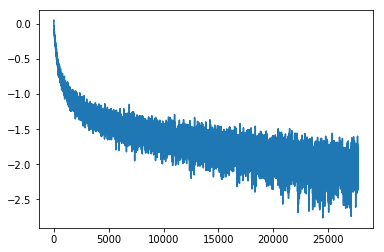

In [87]:
plt.plot(np.log(np.log(loss_val_hist)))

In [88]:
generate(as_matrix(["\x02" + "Hi, there." + "\x03"]), 75, tau=1e-7, n_samples=200, seed=42)

[[("I don't know how.", 0.92403632),
  ('Thank you very much.', 0.93505985),
  ("I'm sorry.", 0.96287441),
  ("Hi. I'm listen to her.", 0.9938246),
  ("How's that?", 1.0093236),
  ("I'll see you...", 1.0616776),
  ('How are you!', 1.0839005),
  ('Hi.', 1.0929443),
  ('Hi.', 1.0929443),
  ('Hi.', 1.0929443),
  ('Hi.', 1.0929443),
  ('Hi.', 1.0929443),
  ('Hi.', 1.0929443),
  ('Hi.', 1.0929443),
  ('Hi.', 1.0929443),
  ('Hi.', 1.0929443),
  ('Hi.', 1.0929443),
  ('This is gonna be here!', 1.1158074),
  ("Hi. Why do I happen, 'cause you don't want to stay around?", 1.1220632),
  ("Oh, yeah, sir, I don't understand.", 1.1529226),
  ('Hi...', 1.1666373),
  ("Hi. And you're going to be Holida...", 1.2077732),
  ("It wasn't me.", 1.2164366),
  ("What's how much to do, Genera?", 1.2226774),
  ("Mr. Thursday, I'm sorry.", 1.2374734),
  ('Good and you gotta be together.', 1.2390307),
  ("I'm here.", 1.2621359),
  ("So you guys, I'm sorry...", 1.263865),
  ('Yeah, shit!', 1.2856348),
  ("I won't 

In [64]:
def softmax(x_ij, axis=-1):
    x_ij = np.exp(x_ij - x_ij.max(axis=axis, keepdims=True))
    return x_ij / x_ij.sum(axis=axis, keepdims=True)

In [65]:
logits = op_predict_logits(be, bd)

rasta = np.random.RandomState(42)
gumbel = -np.log(-np.log(rasta.uniform(size=logits.shape)))


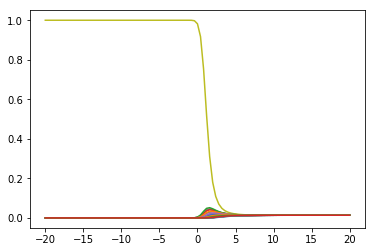

In [66]:
p = gumbel + logits
test = p[0, -10]
ttau = np.logspace(-20, 20, num=101, base=2)[:, np.newaxis]
test = softmax(test[np.newaxis] / ttau)

plt.plot(np.log2(ttau), test);

(array([  4.30355000e+05,   2.61762000e+06,   1.09582100e+06,
          2.05709000e+05,   3.29850000e+04,   5.28500000e+03,
          8.02000000e+02,   1.21000000e+02,   1.80000000e+01,
          2.00000000e+00]),
 array([ -2.69393827,  -0.84279984,   1.00833858,   2.859477  ,
          4.71061543,   6.56175385,   8.41289227,  10.2640307 ,
         12.11516912,  13.96630754,  15.81744597]),
 <a list of 10 Patch objects>)

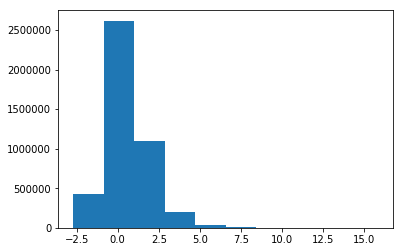

In [66]:
plt.hist(gumbel.flat)

In [71]:
par = lasagne.layers.get_all_params(l_decoder_reembedder)
wgt = dict(zip((p.name for p in par),
                 weights["l_decoder_reembedder"]))

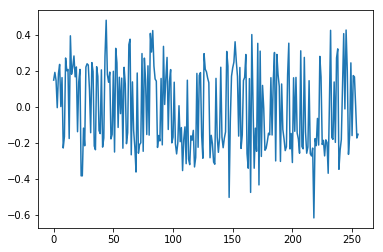

In [80]:
plt.plot(wgt["decoder/gruattn_01.v_attn"])

In [67]:
for k, v, in zip(lasagne.layers.get_all_params(l_decoder_reembedder),
                 weights["l_decoder_reembedder"]):
    print (k, v.shape)

encoder/gru_f.W_in_to_updategate (32, 256)
encoder/gru_f.W_hid_to_updategate (256, 256)
encoder/gru_f.b_updategate (256,)
encoder/gru_f.W_in_to_resetgate (32, 256)
encoder/gru_f.W_hid_to_resetgate (256, 256)
encoder/gru_f.b_resetgate (256,)
encoder/gru_f.W_in_to_hidden_update (32, 256)
encoder/gru_f.W_hid_to_hidden_update (256, 256)
encoder/gru_f.b_hidden_update (256,)
encoder/gru_f.hid_init (1, 256)
encoder/gru_b.W_in_to_updategate (32, 256)
encoder/gru_b.W_hid_to_updategate (256, 256)
encoder/gru_b.b_updategate (256,)
encoder/gru_b.W_in_to_resetgate (32, 256)
encoder/gru_b.W_hid_to_resetgate (256, 256)
encoder/gru_b.b_resetgate (256,)
encoder/gru_b.W_in_to_hidden_update (32, 256)
encoder/gru_b.W_hid_to_hidden_update (256, 256)
encoder/gru_b.b_hidden_update (256,)
encoder/gru_b.hid_init (1, 256)
decoder/gruattn_00.W_in (32, 768)
decoder/gruattn_00.W_ctx (512, 1024)
decoder/gruattn_00.W_hid (256, 1024)
decoder/gruattn_00.b (768,)
decoder/gruattn_00.v_attn (256,)
decoder/gruattn_00.b_at

In [52]:
# for be, bd in generate_batch(32, max_len=128):
#     break

# v_encoder_context = lasagne.layers.get_output(l_encoder_context, inputs)

# op_train(be, bd)

# <hr/>

In [ ]:
# list(zip(trainable[1:], weights["l_decoder_reembedder"]))

In [55]:
for be, bd in generate_batch(32, max_len=512):
    break

In [79]:
op_train(bd, be)

array(2.7703378200531006)

In [68]:
ass = h_0.eval({v_gen_input: be})

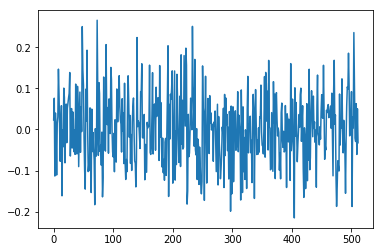

In [69]:
plt.plot(ass[0])

<hr/>

The older generator

In [43]:
# Generator's one step update function
def generator_step(x_tm1, h_tm1, m_tm1, tau, eps):
    """One step of the generative decoder version."""
    # x_tm1 is `batch` int8, h_tm1 is `batch x ...`
    # m_tm1 is `batch`, tau, eps are scalars

    # embed the previous character. x_t is `batch x embed`
    x_t = l_embed_char.get_output_for(x_tm1, deterministic=True)

    # collect the inputs
    inputs = {l_decoder_embed: x_t.dimshuffle(0, "x", 1),
              l_decoder_mask: m_tm1.dimshuffle(0, "x")}

    # Connect the prev variables to the the hidden and stack state feeds
    j = 0
    for layer in dec_rnn_layers:
        inputs[layer.hid_init] = slice_(h_tm1, j, layer.num_units)
        j += layer.num_units

    # Get the outputs
    outputs = [l_decoder_reembedder] + dec_rnn_layers_sliced

    # propagate through the decoder column
    logit_t, *h_t_list = lasagne.layers.get_output(outputs, inputs,
                                                   deterministic=True)

    logit_t = logit_t[:, 0]
    prob_t = tt.nnet.softmax(logit_t)

    # Gumbel-softmax sampling: Gumbel (e^{-e^{-x}}) distributed random noise
    gumbel = -tt.log(-tt.log(theano_random_state.uniform(size=logit_t.shape) + eps) + eps)
#     logit_t = theano.ifelse.ifelse(tt.gt(tau, 0), gumbel + logit_t, logit_t)
#     inv_temp = theano.ifelse.ifelse(tt.gt(tau, 0), 1.0 / tau, tt.constant(1.0))
    logit_t = tt.switch(tt.gt(tau, 0), gumbel + logit_t, logit_t)
    inv_temp = tt.switch(tt.gt(tau, 0), 1.0 / tau, tt.constant(1.0))

    # Pick one element
    x_t = tt.cast(tt.argmax(tt.nnet.softmax(logit_t * inv_temp), axis=-1), x_tm1.dtype)

    # Pack the hidden states
    h_t = tt.concatenate(h_t_list, axis=-1)

    # Compute the mask and inhibit the propagation on a stop symbol.
    # Recurrent layers return the previous state if m_tm1 is Fasle
    m_t = m_tm1 & tt.gt(x_t, vocab.index("\x03"))
    x_t = tt.switch(m_t, x_t, vocab.index("\x03"))

    # There is no need to freeze the states as they will be frozen by
    # the RNN passthrough according to the mask `m_t`.

    # Get the estimated probability of the picked symbol.
    p_t = prob_t[tt.arange(x_t.shape[0]), x_t]
    return x_t, h_t, m_t, p_t

h_0 = tt.concatenate(dec_hid_inits, axis=-1)

x_0 = tt.fill(tt.zeros((v_gen_input.shape[0],), dtype="int32"),
              vocab.index("\x02"))

m_0 = tt.ones((v_gen_input.shape[0],), 'bool')

result, updates = theano.scan(generator_step, sequences=None, n_steps=n_steps,
                              outputs_info=[x_0, h_0, m_0, None],
                              strict=False, return_list=True,
                              non_sequences=[tau, eps], go_backwards=False,
                              name="generator/scan")
x_t, h_t, m_t, p_t = [r.swapaxes(0, 1) for r in result]

compile_mode = theano.Mode(optimizer="fast_run", linker="cvm")
op_generate = theano.function([v_gen_input, n_steps, tau],
                              [x_t, h_t, m_t, p_t],
                              updates=updates, givens={eps: floatX(1e-20)},
                              mode=compile_mode)

def generate(questions, n_steps, n_samples=10, tau=0, seed=None):
    results = []
    for question in questions:
        # Replicate the query
        question = np.repeat(question[np.newaxis], n_samples, axis=0)
        if seed is not None:
            theano_random_state.seed(seed)
        x_t, h_t, m_t, p_t = op_generate(question, n_steps, tau)

        # may produce NaN, but they are shifted in the back by arsort
        perplexity, n_chars = (- np.log2(p_t) * m_t).sum(axis=-1), m_t.sum(axis=-1)
        perplexity /= n_chars

        result = []
        for i in perplexity.argsort():
            reply = "".join(map(vocab.__getitem__, x_t[i, :n_chars[i]]))
            result.append((reply, perplexity[i]))
        results.append(result)
    return results